In [1]:
import warnings
warnings.filterwarnings('ignore')

from src.prepare import telco_model_prep
from src.helper_functions import plot_corr, calc_vif, output_preds, over_split, chi2_significance

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import chi2

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics import recall_score, precision_score, accuracy_score, plot_roc_curve
from sklearn.model_selection import RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

import eli5

# Predicting Telco Churn

[Preprocessing](#preprocessing)

[Modeling](#modeling)

In [2]:
df = telco_model_prep()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   senior_citizen     7043 non-null   int64  
 2   tenure             7043 non-null   int64  
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   male               7043 non-null   uint8  
 6   partner            7043 non-null   uint8  
 7   dependents         7043 non-null   uint8  
 8   phone_service      7043 non-null   uint8  
 9   multiple_lines     7043 non-null   uint8  
 10  dsl                7043 non-null   uint8  
 11  fiber_optic        7043 non-null   uint8  
 12  online_security    7043 non-null   uint8  
 13  online_backup      7043 non-null   uint8  
 14  device_protection  7043 non-null   uint8  
 15  tech_support       7043 non-null   uint8  
 16  streaming_tv       7043 

<a id='preprocessing'></a>
## Preprocessing

**Multicollinearity** is a problem because it undermines the statistical significance of an independent variable. **VIF (Variable Inflation Factors)** are the most common tool for detecting multicollinearity. VIF determines the strength of the correlation between the independent variables. It is predicted by taking a variable and regressing it against every other variable. The VIF score of an independent variable represents how well the variable is explained by other independent variables.

* VIF starts at 1 and has no upper limit
* VIF = 1 -> no correlation between the independent variable and the other variables
* VIF exceeding 10 indicates high multicollinearity

(Source: *What is Multicollinearity? Here’s Everything You Need to Know* by Aniruddha Bhandari)

In [3]:
churn = df.pop("churn") #first, isolate the dependent variable
calc_vif(df.iloc[:,1:])

,variables,VIF
0,senior_citizen,1.4
1,tenure,12.6
2,monthly_charges,4872.4
3,total_charges,17.6
4,male,2.0
5,partner,2.8
6,dependents,2.0
7,phone_service,354.6
8,multiple_lines,12.6
9,dsl,210.5


*Total charges* & *tenure* as well as *fiber optic* & *monthly charges* have correlations of .83 and .79, respectively.

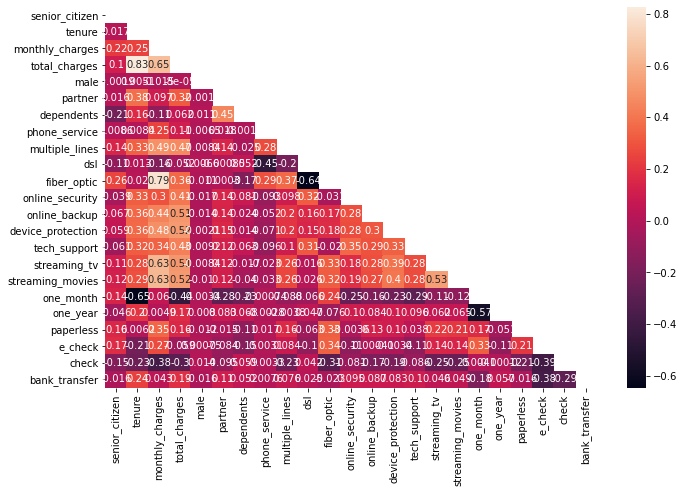

In [4]:
plot_corr(df);

In [4]:
df = df.drop(['monthly_charges', 'total_charges'], axis=1)

In [6]:
calc_vif(df.iloc[:,1:])

,variables,VIF
0,senior_citizen,1.4
1,tenure,5.7
2,male,2.0
3,partner,2.8
4,dependents,1.9
5,phone_service,8.4
6,multiple_lines,2.4
7,dsl,4.8
8,fiber_optic,7.2
9,online_security,2.0


#### Testing for dependence

Next, I used $χ^2$ contingency tables to test the dependence of churn on every categorical variable. If the observed contingency table for a variable did not differ signifacantly from the expected contingency table based on churn rates, I conclude that the variable is not useful for predicting churn.

Only *phone service* and *gender* were independent of churn. (Dropping *phone service* had the added benefit of eliminating the feature with the highest multicollinearity.)

In [5]:
insig_vars = chi2_significance(df, churn)
df = df.drop(insig_vars, axis=1)
insig_vars

Observed
male      0     1
churn            
0      2549  2625
1       939   930
---
Expected
          0       1
No   2562.0  2612.0
Yes   926.0   943.0
---
Bonferroni correction = 4
chi^2 = 0.484
p     = 0.9999


Observed
phone_service    0     1
churn                   
0              512  4662
1              170  1699
---
Expected
         0       1
No   501.0  4673.0
Yes  181.0  1688.0
---
Bonferroni correction = 4
chi^2 = 0.915
p     = 0.9999




['male', 'phone_service']

A note on feature engineering: I attempted to engineer two features. Both had multicollinearity problems while offering no improvements to model performance.

* *Monthly charge bins* collinear with fiber optic
* *Final month of contract* .96 correlated with month-to-month

### Oversampling & Train-Val-Test Split

In [6]:
X_train, X_test, y_train, y_test, X_over, X_val, y_over, y_val = over_split(df, churn, .15)

X_train, X_test, y_train, y_test, X_over, X_val, y_over, y_val
(4929, 19) (1057, 20) (4929,) (1057,) (7242, 19) (1057, 19) (7242,) (1057,)


In [7]:
cid = X_test.pop("customer_id") #needed for output file
pd.DataFrame(X_test.columns, columns=["features"])

,features
0,senior_citizen
1,tenure
2,partner
3,dependents
4,multiple_lines
5,dsl
6,fiber_optic
7,online_security
8,online_backup
9,device_protection


<a id='modeling'></a>
## Modeling

Low recall is a big problem. Accuracy is a distraction with imbalanced classes. The model isn't picking up on why customers leave.

Why not predict all ones?

Karl Popper — 'A theory that explains everything, explains nothing'

THis model is the boy who cried wolf. You have to focus resources on something, or else you will accomplish nothing. Giving equal attention to the 3/4 of satisifed customers will not address the high-value, high-risk customers leaving every month.

In [11]:
#baseline
#tp / (tp + fp) is precision & tp / (tp + fn) is recall
y_pred = np.ones(len(y_test))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       777
           1       0.26      1.00      0.42       280

    accuracy                           0.26      1057
   macro avg       0.13      0.50      0.21      1057
weighted avg       0.07      0.26      0.11      1057



### Non-linear classifiers

### kNN

In [12]:
scores_in, scores_out = [], []
k_values = range(2,31,2)

for k in k_values:
    knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k))
    knn.fit(X_train, y_train)
    scores_in.append(knn.score(X_train, y_train))
    scores_out.append(knn.score(X_val, y_val))                 

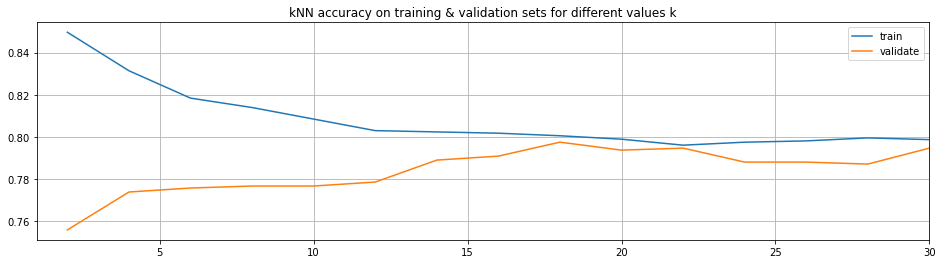

In [13]:
f = plt.subplots(figsize=(16,4))
plt.plot(k_values, scores_in)
plt.plot(k_values, scores_out)
plt.grid()
plt.xlim(1,30)
plt.legend(["train","validate"])
plt.title("kNN accuracy on training & validation sets for different values k");

In [17]:
knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=16))

knn.fit(X_train, y_train)
print(classification_report(y_val, knn.predict(X_val)))

knn.fit(X_over, y_over)
print(classification_report(y_val, knn.predict(X_val)))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       776
           1       0.63      0.51      0.56       281

    accuracy                           0.79      1057
   macro avg       0.73      0.70      0.71      1057
weighted avg       0.78      0.79      0.78      1057

              precision    recall  f1-score   support

           0       0.89      0.77      0.82       776
           1       0.53      0.74      0.62       281

    accuracy                           0.76      1057
   macro avg       0.71      0.75      0.72      1057
weighted avg       0.79      0.76      0.77      1057



### Decision tree

In [49]:
dt = DecisionTreeClassifier(ccp_alpha=.01, random_state=36)

dt.fit(X_train, y_train)
print(classification_report(y_val, dt.predict(X_val)))

dt.fit(X_over, y_over)
print(classification_report(y_val, dt.predict(X_val)))

              precision    recall  f1-score   support

           0       0.80      0.96      0.87       776
           1       0.75      0.35      0.47       281

    accuracy                           0.80      1057
   macro avg       0.78      0.65      0.67      1057
weighted avg       0.79      0.80      0.77      1057

              precision    recall  f1-score   support

           0       0.90      0.72      0.80       776
           1       0.50      0.78      0.61       281

    accuracy                           0.74      1057
   macro avg       0.70      0.75      0.71      1057
weighted avg       0.79      0.74      0.75      1057



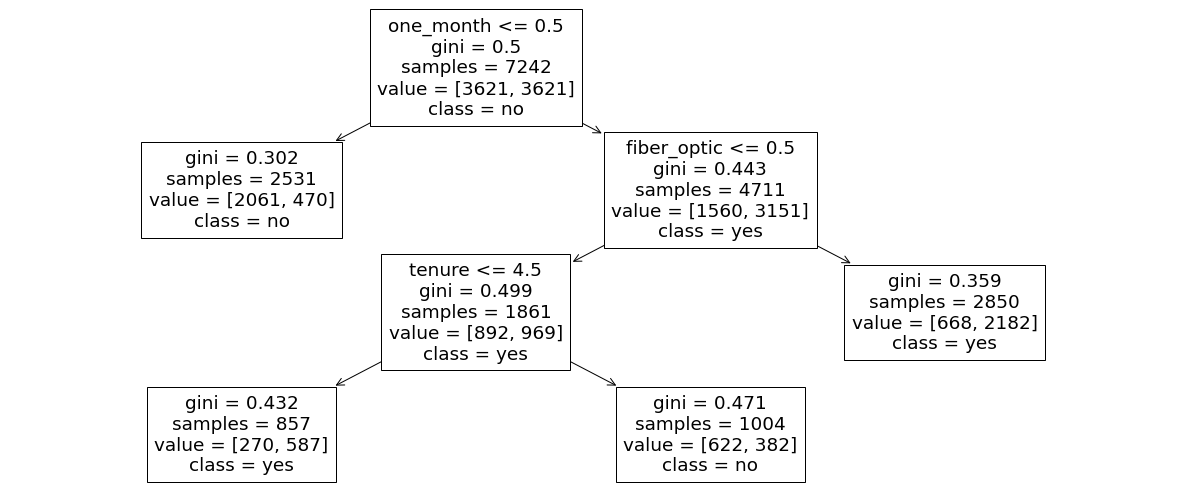

In [27]:
plt.figure(figsize=(21,9))
plot_tree(dt, feature_names=X_val.columns, class_names=['no','yes']);

### Random forest

In [35]:
#ccp_alpha prunes weak links based on impurity, a useless, 100% impure node splits evenly (50/50) whereas a 100% pure node classifies all samples to one class
for a in np.array(range(10, 100, 10))/10000:
    rf = RandomForestClassifier(ccp_alpha=a, random_state=36).fit(X_over, y_over)
    y_pred = rf.predict(X_val)
    print(f"alpha: {a}, recall: {round(recall_score(y_val, y_pred),2)}, f1: {round(f1_score(y_val, y_pred),2)}")    

alpha: 0.001, recall: 0.73, f1: 0.62
alpha: 0.002, recall: 0.79, f1: 0.63
alpha: 0.003, recall: 0.81, f1: 0.63
alpha: 0.004, recall: 0.82, f1: 0.62
alpha: 0.005, recall: 0.82, f1: 0.62
alpha: 0.006, recall: 0.81, f1: 0.61
alpha: 0.007, recall: 0.82, f1: 0.61
alpha: 0.008, recall: 0.83, f1: 0.62
alpha: 0.009, recall: 0.83, f1: 0.61


In [40]:
rf = RandomForestClassifier(ccp_alpha=.003, random_state=36)
rf.fit(X_train, y_train)
print(classification_report(y_val, rf.predict(X_val)))

rf.fit(X_over, y_over)
print(classification_report(y_val, rf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.79      0.95      0.87       776
           1       0.71      0.32      0.44       281

    accuracy                           0.78      1057
   macro avg       0.75      0.64      0.65      1057
weighted avg       0.77      0.78      0.75      1057

              precision    recall  f1-score   support

           0       0.91      0.73      0.81       776
           1       0.52      0.81      0.63       281

    accuracy                           0.75      1057
   macro avg       0.72      0.77      0.72      1057
weighted avg       0.81      0.75      0.76      1057



In [41]:
#ranked importance based on Gini index
eli5.show_weights(rf, feature_names=list(X_val.columns))

Weight,Feature
0.2734 ± 0.4664,one_month
0.2019 ± 0.3306,tenure
0.1434 ± 0.2380,fiber_optic
0.0728 ± 0.2266,e_check
0.0686 ± 0.1725,online_security
0.0548 ± 0.1532,tech_support
0.0421 ± 0.1386,one_year
0.0280 ± 0.1165,dependents
0.0254 ± 0.0756,check
0.0215 ± 0.0563,dsl


### Linear classifiers

In [48]:
lr = make_pipeline(StandardScaler(),LogisticRegression(C=.1, random_state=36))
lr.fit(X_train, y_train)
print(classification_report(y_val, lr.predict(X_val)))

lr.fit(X_over, y_over)
print(classification_report(y_val, lr.predict(X_val)))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       776
           1       0.66      0.49      0.56       281

    accuracy                           0.80      1057
   macro avg       0.74      0.70      0.71      1057
weighted avg       0.78      0.80      0.79      1057

              precision    recall  f1-score   support

           0       0.88      0.77      0.82       776
           1       0.53      0.72      0.61       281

    accuracy                           0.76      1057
   macro avg       0.71      0.75      0.72      1057
weighted avg       0.79      0.76      0.77      1057



In [ ]:
eli5.show_weights(lr, feature_names=list(X_val.columns))

### But is the forest really better than the tree?

The forest had a *slightly* better recall and F1 and a *slightly* worse precision. If the predictions these models made are the same, I choose the decision tree because it is very easy to interpret.

**McNemar’s test** operates upon a contingency table. The contingency table relies on the fact that both classifiers were trained on exactly the same training data and evaluated on exactly the same test data instances. McNemar’s test is a paired nonparametric or distribution-free statistical hypothesis test. The test is checking if the disagreements between two cases match. Here is how the statistic is calculated.

statistic = (Yes/No - No/Yes)^2 / (Yes/No + No/Yes)

Where Yes/No is the count of test instances that Classifier 1 got correct and Classifier 2 got incorrect, and No/Yes is the count of test instances that Classifier 1 got incorrect and Classifier 2 got correct.

This calculation of the test statistic assumes that each cell in the contingency table used in the calculation has a count of at least 25. **The test statistic has a Chi-Squared distribution with 1 degree of freedom.**

We can see that only two elements of the contingency table are used, specifically that the Yes/Yes and No/No elements are not used in the calculation of the test statistic. As such, we can see that the statistic is reporting on the different correct or incorrect predictions between the two models, not the accuracy or error rates.

$H_0$ The two models disagree to the same amount.

$H_1$ There is evidence that the cases disagree in different ways, that the disagreements are skewed.


(Source: *How to Calculate McNemar’s Test to Compare Two Machine Learning Classifiers* by Jason Brownlee)

In [85]:
pd.crosstab(rf.predict(X_val)==y_val, dt.predict(X_val)==y_val)

churn,False,True
churn,,
False,229,36
True,49,743


In [91]:
t, ddof = (49 - 36)**2 / (49 + 36), 1
p = chi2.sf(t, ddof)
print(f" McNemar's t-stat: {round(t,2)}, p-value: {round(p,2)}")

 McNemar's t-stat: 1.99, p-value: 0.16


<img src="img/chi2_table.png">

**Conclusion: Do not reject the null** at a significance below of 0.16. The models disagree to the same amount.

For the final step, I output the decision tree predictions to a file.

In [89]:
output_preds(dt, X_test, y_test, cid)

DecisionTreeClassifier(ccp_alpha=0.01, random_state=36), 
    recall: 0.79,
    precision: 0.52,
    f1: 0.63,
    accuracy: 0.75

 customers: 1057, predicted to churn: 423, did churn: 280


### Is this better than the baseline? 
Before: 7000 customers had a 1/4 chance of churning

After: 3400 customers have a 1/2 chance of churning

Our new model is guessing churn correctly about half of the time (precision ~ .5)
Of those churn predictions, 9/10 customers leaving were correctly identified (recall ~ .9)

Knowing a customer is as likely to churn as not makes him/her at-risk.
At-risk customers can be targeted with promotions and customer support.
One example would be to text all at-risk customers a promotion such as:

"As a thank you for being a valued customer, we would like to offer you 50% off next month's bill."